### 필요한 모듈들 import 해주기

In [1]:
# pip install nltk
# nltk 는 자연어 처리를 위한 파이썬 패키지임

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
# 불용어 파일을 다운로드 받아주기
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gherwt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# 영어에 있는 불용어들을 확인
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:
# data 폴더에 있는 train 파일 가져오고 확인하기
news_data = pd.read_csv('./data/train.csv')
news_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
# news_data 의 구성 확인
news_data.shape

(20800, 5)

In [7]:
# Dataset 의 null 값을 확인해주기
news_data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
# null 값을 전처리 해주기
news_data = news_data.fillna('')

In [9]:
# Dataset 의 null 값을 확인해주기
news_data.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [10]:
# content column 생성 : author 와 title 의 내용을 합쳐준다.
news_data['content'] = news_data['author']+' '+news_data['title']

In [11]:
# content 내용 확인
print(news_data['content'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object


In [12]:
# Data 와 Label 을 분리해주기

## label 을 기준으로 모델링 진행하기 위해서 따로 분리해서 저장해줌
X = news_data.drop(columns='label', axis=1)

## label을 feature 변수로 저장
Y = news_data['label']

In [13]:
# 분리한 데이터들 확인해주기

Y.value_counts()

X.shape

Y.shape

print(X)
print(Y)


          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

### STEMMING(어간 추출):

   - STEMMING 알고리즘은 언어 정규화 과정의 일종으로, 단어의 변형된 형태를 공통된 기본 형태로 변환하는 작업입니다. 
   - 좀 더 간단하게 말하자면, stemming은 단어를 **어근, 어간 (root word)**으로 줄이는 과정입니다.

### 예시:

   - actor, actress, acting --> act
   - eating, eats, eaten --> eat

In [19]:
port_stem = PorterStemmer()

In [20]:
# review data 생성하기
def stemming(content):
    # 정규 표현식 사용, 알파벳 문자를 제외한 모든 문자를 의미
    review = re.sub('[^a-zA-Z]',' ',content)
    # 소문자 변환
    review = review.lower()
    # 단어를 분리해준다.
    review = review.split()
    # 불용어 목록에 속한 단어들을 제거하고 어근을 추출한다.
    review = [port_stem.stem(word) for word in review if not word in stopwords.words('english')]
    # 결과를 join 으로 연결해주고 review 를 반환해준다.
    review = ' '.join(review)
    return review

In [21]:
# content 에서 어근들을 추출한다.
news_data['content'] = news_data['content'].apply(stemming)

In [22]:
# label 과 content 를 분리해준다.
X = news_data['content'].values
Y = news_data['label'].values

In [23]:
# content 확인
print(X)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']


In [26]:
# label을 확인
print(Y)

[1 0 1 ... 0 1 1]


In [25]:
Y.shape

(20800,)

## TF-IDF 이해: 단어 중요도 측정

**TF-IDF** (Term Frequency-Inverse Document Frequency)는 문서에서 단어의 중요도를 측정하는 통계량입니다. 

* **단어 빈도 (Term Frequency, TF):** 특정 단어가 **문서 내에 얼마나 자주 등장하는지** 를 나타내는 값입니다. 
    * TF값이 높을수록 그 단어는 문서에서 중요하다고 생각할 수 있습니다.

* **역 문서 빈도 (Inverse Document Frequency, IDF):** 특정 단어가 **문서 집합 전체에서 얼마나 드문지** 를 나타내는 값입니다. 
    * 문서 집합에서 모든 문서에 자주 등장하는 단어 (예: the, a)는 IDF 값이 낮아지고, 특정 문서에서만 많이 쓰이는 단어 (예: 전문 용어)는 IDF 값이 높아집니다. 

**TF-IDF 계산:**

* TF-IDF 값은 일반적으로 TF와 IDF 값을 곱하여 계산됩니다. 


**왜 TF-IDF를 사용할까요?**

* 단순히 단어 빈도만 사용하면 "the", "a"와 같은 출현 빈도가 높은 단어들이 중요하게 평가될 수 있습니다.
* TF-IDF는 이러한 단어들의 중요도를 낮추고 문서에서 차별적인 의미를 가진 단어들의 중요도를 높여 분석의 정확성을 높입니다.

**활용 분야:**

* 검색 엔진: 문서와 사용자 질의 간의 관련성을 측정하는 데 사용
* 텍스트 마이닝: 주요 단어, 문서 군집화 등에 활용
* 문서 요약: 중요한 단어를 기반으로 문서 요약 생성

**TF-IDF를 이해하면 텍스트 데이터 분석에서 단어의 중요도를 효과적으로 파악할 수 있습니다.**

In [27]:
# 문자 data 를 숫자로 변환해주기
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

In [28]:
print(X)

  (0, 15686)	0.28485063562728646
  (0, 13473)	0.2565896679337957
  (0, 8909)	0.3635963806326075
  (0, 8630)	0.29212514087043684
  (0, 7692)	0.24785219520671603
  (0, 7005)	0.21874169089359144
  (0, 4973)	0.233316966909351
  (0, 3792)	0.2705332480845492
  (0, 3600)	0.3598939188262559
  (0, 2959)	0.2468450128533713
  (0, 2483)	0.3676519686797209
  (0, 267)	0.27010124977708766
  (1, 16799)	0.30071745655510157
  (1, 6816)	0.1904660198296849
  (1, 5503)	0.7143299355715573
  (1, 3568)	0.26373768806048464
  (1, 2813)	0.19094574062359204
  (1, 2223)	0.3827320386859759
  (1, 1894)	0.15521974226349364
  (1, 1497)	0.2939891562094648
  (2, 15611)	0.41544962664721613
  (2, 9620)	0.49351492943649944
  (2, 5968)	0.3474613386728292
  (2, 5389)	0.3866530551182615
  (2, 3103)	0.46097489583229645
  :	:
  (20797, 13122)	0.2482526352197606
  (20797, 12344)	0.27263457663336677
  (20797, 12138)	0.24778257724396507
  (20797, 10306)	0.08038079000566466
  (20797, 9588)	0.174553480255222
  (20797, 9518)	0.295420

In [30]:
# train, test data 로 분리하고 학습을 진행하기
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

## 로지스틱 회귀 (Logistic Regression)

**로지스틱 회귀**는 기존 데이터 세트의 관찰을 기반으로 이진 분류 문제 (예: 예/아니오, 성공/실패)를 예측하는 통계 분석 방법입니다. 

**핵심 개념:**

* **이진 분류 (Binary Classification):** 데이터를 두 개의 카테고리 (예: 긍정/부정, 스팸/일반)로 분류하는 작업
* **종속 변수 (Dependent Variable):** 예측하려는 변수 (예: 이메일이 스팸인지 아닌지)
* **독립 변수 (Independent Variable):** 종속 변수에 영향을 미치는 변수들 (예: 이메일 본문의 단어, 발신자 정보)


## 로지스틱 회귀 모델은 다음과 같은 과정을 통해 작동합니다.

1. **데이터 준비:** 독립 변수와 종속 변수 (이진 값)로 구성된 데이터 세트를 준비
2. **모델 학습:** 학습 알고리즘은 독립 변수와 종속 변수 간의 관계를 학습
3. **예측:** 새로운 데이터 포인트가 주어지면 모델은 해당 데이터가 각 클래스에 속할 확률을 계산. 예를 들어, 이메일이 스팸일 확률과 일반 메일일 확률을 계산합니다. 
4. **결정 임계값 설정:**  사용자가 임계값을 설정하여 예측 결과를 결정. 예를 들어, 스팸일 확률이 70% 이상이면 스팸으로 분류합니다.

**로지스틱 회귀는 다음과 같은 이유로 널리 사용됨**

* 간단하고 해석하기 쉬운 모델
* 이진 분류 문제에 효과적
* 모델 학습 및 예측 속도가 빠르다

**활용 분야:**

* 스팸 필터링
* 고객 이탈 예측
* 신용 부정 판단
* 의료 진단

**로지스틱 회귀는 다양한 분야에서 이진 분류 문제 해결에 유용한 도구입니다.**


In [31]:
model = LogisticRegression()

In [32]:
model.fit(X_train, Y_train)

LogisticRegression()

In [33]:
# train data 의 정확도를 측정
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [37]:
print('train data의 정확도 : ', training_data_accuracy)

train data의 정확도 :  0.9865985576923076


In [35]:
# test data 의 정확도를 측정
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [38]:
print('test data 의 정확도 : ', test_data_accuracy)

test data 의 정확도 :  0.9790865384615385


## 혼동 행렬 (Confusion Matrix)

* 혼동 행렬은 분류 모델의 성능을 평가하는 데 사용되는 시각적 도구. 

* 2차원 표 형태로 이루어져 있으며, 실제 클래스 (True Label)와 예측된 클래스 (Predicted Label)의 비교 결과를 요약합니다.


**혼동 행렬 구성**

|             | 예측된 클래스 A | 예측된 클래스 B |
|-------------|-----------------|-----------------|
| 실제 클래스 A | True Positive (TP) | False Negative (FN) |
| 실제 클래스 B | False Positive (FP) | True Negative (TN) |

* **True Positive (TP):** 실제 클래스 A이고 모델이 정확하게 A로 예측한 경우
* **False Negative (FN):** 실제 클래스 A이지만 모델이 B로 잘못 예측한 경우 (누락 오류)
* **False Positive (FP):** 실제 클래스 B이지만 모델이 A로 잘못 예측한 경우 (위증 오류)
* **True Negative (TN):** 실제 클래스 B이고 모델이 정확하게 B로 예측한 경우


**혼동 행렬 활용**

* **정확도 (Accuracy):** 전체 예측 중 정확한 예측 비율 ( (TP + TN) / 전체 샘플 수 )
* **정밀도 (Precision):** 모델이 A라고 예측한 것 중 실제로 A인 비율 ( TP / (TP + FP) )
* **재현율 (Recall):** 실제 클래스 A인 데이터 중 모델이 A라고 예측한 비율 ( TP / (TP + FN) )
* **F1 Score:** 정밀도와 재현율의 조화평균 ( 2 * (정밀도 * 재현율) / (정밀도 + 재현율) )

**혼동 행렬은 모델의 성능을 간편하게 시각화하고 다양한 평가 지표 계산에 기초가 되는 중요한 도구임.**

In [39]:
import itertools
import matplotlib.pyplot as plt

# 혼동 행렬을 시각화하는 함수
# cm: 혼동 행렬 (2차원 배열)
# classes: 분류 클래스 목록
# normalize: 혼동 행렬을 정규화할지 여부
# title: 그래프 제목
# cmap: 컬러맵
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    # 히트맵 형태로 시각화
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # 정규화 여부에 따라서 혼동 행렬 값을 표시함
    # True 인 경우
    # 각 행의 합을 1로 조정, 클래스 분포 차이를 반영하지 않은 비율을 표시
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    # 거짓인 경우 원래 혼동 행렬 값을 그대로 표시
    else:
        print('Confusion matrix, without normalization')
    # thresh 변수는 혼동 행렬 값의 배경색을 결정하는 임계값임
    thresh = cm.max() / 2.

    # 혼동 행렬의 모든 셀을 반복합니다.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    # 그래프 layout 자동 조정
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [40]:
# train, test 를 분리하고 학습을 진행시킴
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X, Y, test_size=0.33, random_state=42)


## 다항 분포 나이브 베이즈 분류 (Multinomial Naive Bayes)

* **MNB는 간단하면서도 효과적인 텍스트 분류 알고리즘이며, 다양한 NLP 분야에서 활용 가능합니다.**

* 다항 분포 나이브 베이즈 (Multinomial Naive Bayes, MNB)는 텍스트 분류 문제에 널리 사용되는 확률 기반 학습 알고리즘이다. 

* 특히 자연어 처리 (Natural Language Processing, NLP) 분야에서 자주 사용

* 단어 출현 빈도를 문서 길이로 나누어 정규화하는 경우가 많다

* 이 정규화는 TF-IDF (Term Frequency-Inverse Document Frequency)와 같은 기법을 사용하여 단순 출현 빈도보다는 문서 내 중요성을 더 반영하는 값을 계산하는 데 사용됩니다.

**2. 기본 원리**

MNB는 "나이브 베이즈" 분류 알고리즘의 한 종류이며, 이는 각 특징 (feature) 간의 독립성을 가정하는 베이즈 정리를 기반으로 작동합니다. 

텍스트 분류의 경우, 특징은 단어들이며 클래스는 텍스트가 속하는 카테고리 (예: 스팸/일반 메일, 긍정/부정 리뷰)를 나타냅니다.

**3. 작동 방식:**

1. **문서 전처리:** 텍스트 데이터에서 불용어 제거, 어근 추출 등 전처리 과정을 거칩니다.
2. **모델 학습:** 학습 데이터를 기반으로 각 클래스별로 단어 출현 빈도 (Term Frequency, TF)를 계산
    - TF는 단어가 문서에 ``얼마나 자주 등장``하는지를 나타내는 값입니다.
3. **문서 분류:** 새로운 문서가 들어오면 MNB는 각 클래스에서 해당 단어가 등장할 확률을 계산합니다.
    - 나이브 베이즈 가정에 따라 각 단어의 출현은 서로 독립적이라고 가정합니다.
    - 베이즈 정리를 사용하여 문서가 속할 가장 가능성이 높은 클래스를 예측합니다.

**4. 장점:**

* 간단하고 해석하기 쉬운 알고리즘
* 빠른 학습 및 예측 속도
* 적은 메모리 요구량

**5. 단점:**

* 특징 간의 독립성 가정이 항상 성립하지 않음
* 희소 데이터 (특정 단어가 거의 등장하지 않음)에 취약

**6. 활용 분야:**

* 스팸 필터링
* 감정 분석
* 문서 분류

In [49]:
# Multinomial Naive Bayes 를 classifier 로 설정하고 실행하기
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

정확도:   0.950
Confusion matrix, without normalization


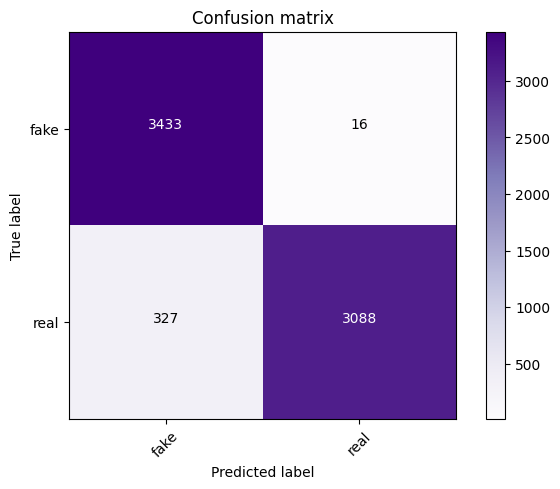

In [50]:
from sklearn import metrics
import numpy as np
import itertools

classifier.fit(X1_train, Y1_train)
prediction1 = classifier.predict(X1_test)
score = metrics.accuracy_score(Y1_test, prediction1)
# 정확도 점수 
print("정확도:   %0.3f" % score)
# 혼동 행렬로 예측의 정확도 점수를 나타낸다
cm1 = metrics.confusion_matrix(Y1_test, prediction1)
plot_confusion_matrix(cm1, classes=['fake', 'real'])

## Passive Aggressive Classifier(PMLB)

* PMLB는 분류 문제에 사용되는 기계 학습 알고리즘이다.

* **PMLB는 온라인 학습과 큰 데이터 처리에 적합한 알고리즘이지만, 예측 성능 측면에서는 다른 분류 알고리즘에 비해 다소 부정확할 수 있다.**

**핵심 개념**

* **모델 학습** 
    * 학습 데이터를 기반으로 분류 모델을 생성
    * 이 알고리즘은 모델이 새로운 데이터를 올바르게 분류할 때는 **소극적으로** 업데이트를 진행
    * 하지만 모델이 실수를 할 때는 **적극적으로** 업데이트를 진행하여 오류를 교정

**작동 방식**

1. **초기 모델 설정:** 간단한 초기 모델 (예: 선형 회귀)을 설정합니다.
2. **데이터 순차 처리:** 
    * 각 데이터 포인트를 순차적으로 가져옵니다.
    * 모델이 해당 데이터 포인트를 예측합니다.
3. **예측 평가:**
    * 예측 결과가 실제 클래스와 일치하면 아무 업데이트를 하지 않습니다.
    * 예측 결과가 틀리면 모델을 업데이트합니다.
        * 업데이트 방식은 실수의 정도에 따라 조정됩니다. 
        * 큰 실수일 경우 더 큰 조정을 수행하여 모델을 빠르게 학습시킵니다.
4. **반복 학습:** 2~3 과정을 반복하여 데이터 전체를 기반으로 모델을 학습시킵니다.

**장점**

* 온라인 학습 (Online Learning)에 적합합니다. 즉, 데이터가 실시간으로 스트리밍되는 환경에서 효과적입니다.
* 메모리 사용량이 적습니다. 
* 큰 데이터셋을 다루는데 적합합니다.

**단점**

* 다른 분류 알고리즘에 비해 예측 성능이 다소 낮을 수 있습니다.
* 하이퍼 파라미터 조정이 민감합니다. 적절한 하이퍼 파라미터 설정이 중요합니다.

**활용 분야**

* 스팸 필터링
* 감정 분석
* 텍스트 분류
* 금융 사기 감지

In [52]:
# train, test 로 분류하고 학습을 진행함.
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X, Y, test_size=0.33, random_state=42)

accuracy:   0.990
Confusion matrix, without normalization


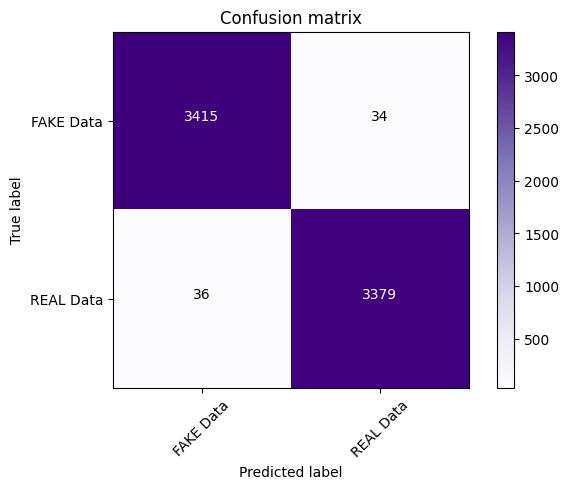

In [53]:
# Passive Aggressive Classifier 를 적용하여 실행
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(max_iter=50)

# 모델 학습을 실행, 선형 분류기 모델
linear_clf.fit(X2_train, Y2_train)

# 모델의 평가를 진행
# 예측을 진행하고 정확도를 평가함
prediction2 = linear_clf.predict(X2_test)
score = metrics.accuracy_score(Y2_test, prediction2)
print("accuracy:   %0.3f" % score)

# 혼동행렬을 생성
cm2 = metrics.confusion_matrix(Y2_test, prediction2)
plot_confusion_matrix(cm2, classes=['FAKE Data', 'REAL Data'])

In [63]:
# 로지스틱 회귀를 사용하여 dataset 의 첫단어를 통해 진짜인지 가짜인지 확인하는 예측 시스템 구축

In [54]:
# X_new 에서 첫단어를 가져옴
X_new = X_test[0]

# 로지스틱 회귀를 사용, 예측을 진행함
prediction = model.predict(X_new)
print(prediction)

# 뉴스의 진위 여부를 판단함.
if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[1]
The news is Fake


In [55]:
print(Y_test[0])

1


In [56]:
# 다항 분포 나이브 베이즈 분류 를 사용하여 dataset 의 첫단어를 통해 진짜인지 가짜인지 확인하는 예측 시스템 구축

In [57]:
# X2_new 에서 첫단어를 가져옴
X2_new = X2_test[0]

# 다항 분포 나이브 베이즈 분류 활용 예측을 진행함
prediction = model.predict(X2_new)
print(prediction)

# 뉴스의 진위여부를 판단함
if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[1]
The news is Fake


In [58]:
print(Y2_test[0])

1


## 분류 보고서 (Classification Report)

분류 보고서는 분류 알고리즘의 예측 품질을 측정하는 데 사용하고 다음과 같은 지표를 포함하여 학습된 분류 모델의 성능을 보여줍니다.

* **정밀도 (Precision):** 실제 양성(positive) 클래스로 예측된 데이터 중 실제로 양성인 데이터의 비율입니다. (예측한 "가짜" 뉴스 기사 중 실제로 가짜 뉴스 기사였던 비율)
* **재현율 (Recall):** 실제 양성 클래스 데이터 중 모델이 양성으로 예측한 데이터의 비율입니다. (실제 가짜 뉴스 기사 전체 중 모델이 가짜라고 예측한 비율)
* **F1 스코어 (F1-Score):** 정밀도와 재현율의 조화 평균입니다. 일반적으로 이 두 지표의 균형 잡힌 성능을 나타냅니다.
* **지원 벡터 (Support):** 각 클래스에 속하는 데이터의 총 개수입니다. (데이터셋 전체에서 실제 "진짜" 뉴스 기사의 수, 실제 "가짜" 뉴스 기사의 수)

**예시:**

```
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      100
           1       0.85      0.90      0.87       50

    accuracy                           0.89      150
    macro avg       0.88      0.89      0.88      150
    weighted avg       0.90      0.89      0.89      150
```

이 예시에서:

* 모델은 클래스 0 (예: 진짜 뉴스) 데이터를 더 정확하게 예측했습니다(정밀도 0.92).
* 하지만 클래스 1 (예: 가짜 뉴스) 데이터의 전체를 식별하는 데는 다소 부족했습니다(재현율 0.90).
* F1 스코어는 0.89로 두 클래스의 성능 간의 균형을 보여줍니다.
* 총 150개의 데이터 포인트가 있으며 클래스 0은 100개, 클래스 1은 50개입니다.

**분류 보고서는 모델의 강점과 약점을 파악하는 데 도움이 되며 모델 개선 전략 수립에 중요한 정보를 제공합니다.**

In [59]:
# 로지스틱 모델을 활용한 분류 보고서 작성

from sklearn.metrics import classification_report
print(classification_report(Y_test, X_test_prediction))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2077
           1       0.97      0.99      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



In [60]:
# 다항 분포 나이브 베이즈 분류 보고서 작성
print(classification_report(Y1_test,prediction1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3449
           1       0.99      0.90      0.95      3415

    accuracy                           0.95      6864
   macro avg       0.95      0.95      0.95      6864
weighted avg       0.95      0.95      0.95      6864



In [61]:
# Passive Aggressive(PMLB) 분류 보고서 작성
print(classification_report(Y2_test,prediction2))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3449
           1       0.99      0.99      0.99      3415

    accuracy                           0.99      6864
   macro avg       0.99      0.99      0.99      6864
weighted avg       0.99      0.99      0.99      6864



MODEL COMPARISON

Hence, in this dataset we can observe that

Logistic Regression : Accuracy is 0.98

Multinomial Naive Bayes : Accuracy is 0.95

Passive Aggressive Classifier : Accuracy is 0.99

In [62]:
print("Successfully we have predicted the fake news using logistic regression, Multinomial Naive Bayes & Passive Aggressive Classifier ")

Successfully we have predicted the fake news using logistic regression, Multinomial Naive Bayes & Passive Aggressive Classifier 
